In [11]:
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from scipy import sparse

%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data/")

ORDERS = os.path.join(DATA_DIR, "orders.csv")
REVIEWS = os.path.join(DATA_DIR, "reviews.csv")
SIZE_MAPPINGS = os.path.join(DATA_DIR, "size_mapping.csv")
STYLE_ATTR = os.path.join(DATA_DIR, "style_attributes.csv")
USER_ATTR = os.path.join(DATA_DIR, "user_attributes.csv")

DATE_FRMT = "%Y-%m-%d"

#Read in data
orders = pd.read_csv(ORDERS)
reviews = pd.read_csv(REVIEWS)
#size_mappings = pd.read_csv(SIZE_MAPPINGS)
#style_attr = pd.read_csv(STYLE_ATTR)
#user_attr = pd.read_csv(USER_ATTR)


In [3]:
def to_dates(df, cols):
    _df = df.copy()
    for col in cols:
        _df[col] = pd.to_datetime(df[col], format=DATE_FRMT)
    return _df

# Orders

 - 1231230 total records, only 1228395 are unique order_ids (~3000 duplicates)
 - 35000 unique user_ids (top has ~ 300 orders)
 - ordered_date between 2017-01-01 and 2018-03-31
 - rental begins between 2017-01-04 and 2018-07-14 (about 1.5 years of data)
 - 4000 unique styles, top 1551
 - 24167 unique skus top 556
 - no missing values
 
 # Questions
 - Why duplicate order_ids?  Are they full-row duplicates (Yes)
 - distribution of user order frequency, how many repeat interactions
 - Last date for ordered_date id 2018-03-31, last date for rental begins is 2018-07-14 (does this imply 3.5 month lag?)
 - does days_rented correlate to satisfaction / fit
 
 ## Collobartive Filtering 
 


In [4]:
orders = to_dates(orders, ['ordered_date', 'rental_begin_date'])
orders.drop_duplicates(inplace=True)
orders.describe(include='all')


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
count,1228395,1228395,1228395,1228395,1228395,1228395,1.228395e+06
unique,1228395,35000,433,378,4000,24167,NaN
top,cfa10af2-c6da-30d3-b421-6ab19ef09ad1,a44957e3-180b-3fe0-a2e6-ef83b2cc17c5,2017-10-17 00:00:00,2017-12-20 00:00:00,SAL28,KS95_ONESIZE,NaN
freq,1,307,9436,12296,1549,556,NaN
first,NaN,NaN,2017-01-01 00:00:00,2017-01-04 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-03-31 00:00:00,2018-07-14 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.242047e+01
std,NaN,NaN,NaN,NaN,NaN,NaN,2.997819e+01
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00


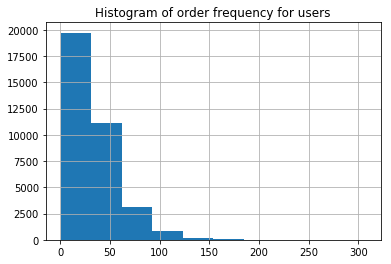

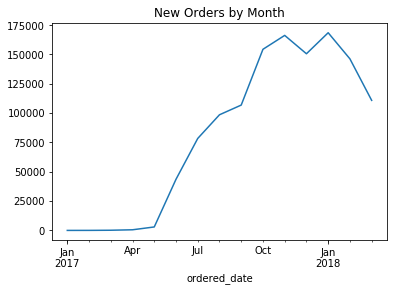

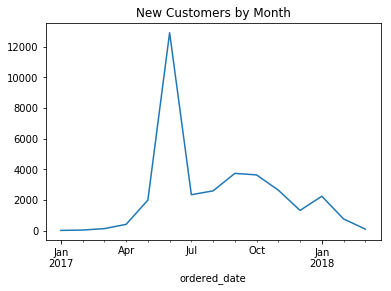

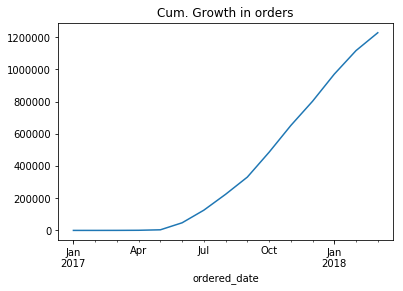

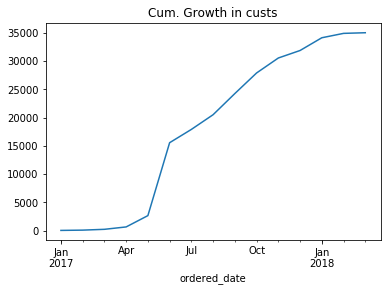

In [5]:
def make_orders_plots(df):
    _df = df.copy()
    
    plt.figure()
    ax = plt.gca()
    _df[['user_id']].apply(pd.value_counts).hist(ax=ax)
    ax.set_title("Histogram of order frequency for users")

    
    _df = _df.set_index("ordered_date").sort_index()
    _df['order_cnt'] = 1
    _df['cust_cnt'] = ~_df['user_id'].duplicated()
    _df['order_cum'] = _df['order_cnt'].cumsum()
    _df['cust_cum'] = _df['cust_cnt'].cumsum()
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Orders by Month")

    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Customers by Month")
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in orders")
    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in custs")

make_orders_plots(orders)

In [6]:
from pandas.api.types import CategoricalDtype
reviews.drop_duplicates(inplace=True)
reviews['did_you_wear_it'] = reviews['did_you_wear_it'].astype('category')

like_it_cat_type = CategoricalDtype(categories=['just_okay', 'liked_it', 'loved_it'], ordered=True)
reviews['how_did_you_like_it'] = reviews['how_did_you_like_it'].astype(like_it_cat_type)

reviews['didnt_fit'] = reviews['didnt_fit'].astype('category')
reviews['size_overall'] = reviews['size_overall'].astype('category')
reviews['size_chest'] = reviews['size_chest'].astype('category')
reviews['size_waist'] = reviews['size_waist'].astype('category')
reviews['size_waist.1'] = reviews['size_waist.1'].astype('category')
reviews['length'] = reviews['length'].astype('category')
reviews['not_flattering'] = reviews['not_flattering'].astype('category')
reviews['not_my_style'] = reviews['not_my_style'].astype('category')
reviews['other_issue'] = reviews['other_issue'].astype('category')

In [7]:
#reviews = to_dates(reviews, ['reviewed_date'])
reviews.describe(include='all')
#reviews.size_overall.value_counts()

,order_id,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
count,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395
unique,1228395,287,2,3,2,4,4,4,4,4,4,2,2,2
top,cfa10af2-c6da-30d3-b421-6ab19ef09ad1,2018-03-06,1,loved_it,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
freq,1,9536,832228,490571,1092882,1092882,1092882,1092882,1092882,1092882,1092882,1103353,1175706,1116430


In [35]:
import gc
def prepare_data(orders_df, reviews_df):
    
    _orders_df = orders_df.copy()
    _reviews_df = reviews_df.copy()
    _orders_df.set_index("order_id", inplace=True)
    joined = reviews_df.join(_orders_df, how='left', on="order_id")
    joined = joined[['user_id','style','didnt_fit']]
    #print(_df.shape)
    #_df= _df[~_df.duplicated(['user_id', 'sku'])]
    #print(_df.shape)
    joined['didnt_fit'] = joined['didnt_fit'].astype(int)
    joined.loc[joined['didnt_fit'] == 0, 'didnt_fit'] = 10
    return joined
    #return pd.pivot_table(_df, values='didnt_fit',index='user_id',columns='sku',aggfunc=np.mean)
    #return _df
    #return _df.pivot(index='user_id', columns='sku', values='didnt_fit')
    #return joined.groupby(['user_id','sku'])['didnt_fit'].mean().unstack()
    
j = prepare_data(orders, reviews)
gc.collect()
g = j.groupby(['user_id','style'])['didnt_fit'].mean().unstack()

0          10
1          10
2          10
3          10
4           1
5          10
6          10
7          10
8          10
9          10
10         10
11         10
12         10
13         10
14         10
15          1
16         10
17         10
18         10
19         10
20         10
21         10
22         10
23          1
24          1
25         10
26          1
27         10
28         10
29         10
           ..
1231200     1
1231201     1
1231202     1
1231203     1
1231204    10
1231205    10
1231206    10
1231207     1
1231208    10
1231209     1
1231210    10
1231211     1
1231212     1
1231213    10
1231214    10
1231215    10
1231216     1
1231217     1
1231218    10
1231219    10
1231220     1
1231221     1
1231222    10
1231223     1
1231224    10
1231225    10
1231226    10
1231227     1
1231228     1
1231229     1
Name: didnt_fit, Length: 1228395, dtype: int64


In [41]:
inds = np.nonzero(~np.isnan(g.values))
sps = sparse.coo_matrix((g.values[inds], inds), shape = g.shape)
sps2 = sparse.dok_matrix(sps)
print(sps.nnz)

1163193


In [53]:
# counter = 0
# for i in sps2.items():
#     counter += 1
#     print(i[0][0], i[0][1], i[1])
#     if counter > 10:
#         break
        
np.mean(sps2)
sps2.mean()

0.07484777227040817

In [ ]:
import math
user_attr = pd.read_csv(USER_ATTR)
user_attr['bmi'] = (user_attr['weight_lbs'] / user_attr['height_in'].pow(2))*703
df = pd.DataFrame(g.index)
user_attr.set_index('user_id', inplace=True)
df = df.join(user_attr,on='user_id',how='left')

In [54]:
class MF():

    def __init__(self, R, K, user_attr, alpha, beta1, beta2, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (dok_sparse matrix)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        self.min_size = user_attr['size'].min()
        self.size_incr = 1
        self.n_size = self.get_idx(user_attr['size'].max()) + 1
        
        self.min_height = user_attr['height_in'].min()
        self.height_incr = 1
        self.n_height = self.get_idx(user_attr['height_in'].max()) + 1
        
        self.min_weight = user_attr['weight_lbs'].min()
        self.weight_incr = 5
        self.n_weight = self.get_idx(user_attr['weight_lbs'].max()) + 1
        
        self.min_bmi = user_attr['bmi'].min()
        self.bmi_incr = 2
        self.n_bmi = self.get_idx(user_attr['bmi'].max()) + 1
                        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.iterations = iterations
        self.sizes = np.random.normal(scale=1./self.K, size=(self.n_size, self.K))
        self.heights = np.random.normal(scale=1./self.K, size=(self.n_height, self.K))
        self.weights = np.random.normal(scale=1./self.K, size=(self.n_weight, self.K))
        self.bmis = np.random.normal(scale=1./self.K, size=(self.n_bmi, self.K))
        
        self.user_data = user_attr.to_dict('records')

    def get_idx(x, kind=['size, weight, height, bmi']):
        if kind == 'size':
            return math.floor((s - self.min_size) / self.size_incr)
        
        if kind == 'height':
            return math.floor((h - self.min_height) / self.height_incr)
        
        if kind == 'weight':
            return math.floor((h - self.min_weight) / self.weight_incr)
        
        if kind == 'bmi':
            return math.floor((h - self.min_bmi) / self.bmi_incr)
    
    def get_vec(x, kind):
        
        if np.isnan(x):
            return zeros(1,self.K)
        
        idx = get_idx(x, kind)
        
        if kind == 'size':
            return self.sizes[idx,:]
        
        if kind == 'height':
            return self.heights[idx,:]
        
        if kind == 'weight':
            return self.weights[idx,:]
        
        if kind == 'bmi':
            return self.bmis[idx,:]
    
                          
    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R)

        # Create a list of training samples
        self.samples = [
            (i[0][0], i[0][1], i[1])
            for i in self.R.items()
        ]
                              

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            user_dict = self.user_data[i]
            
            size_idx = self.get_idx(user_dict.size, 'size')
            if np.isnan(size_idx):
                
            size_vec = self.get_vec(user_dict.size, 'size')
            height_vec = self.get_vec(user_dict.height, 'height')
            weight_vec = self.get_vec(user_dict.weight, 'weight')
            bmi_vec = self.get_vec(user_dict.bmi, 'bmi')
            user_vec = size_vec + beight_vec + weight_vec + bmi_vec
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta1 * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta1 * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta2 * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta2 * self.Q[j,:])
            
            # update user features
            self.sizes[]

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [55]:
test = MF(sps2, 100, .007, .005, .015, 50)

In [56]:
test.train()

Iteration: 10 ; error = 1810.5907
Iteration: 20 ; error = 537.2089
Iteration: 30 ; error = 300.6435
Iteration: 40 ; error = 226.3825
Iteration: 50 ; error = 192.7275


[(0, 3203.236944936769),
 (1, 2877.6032578652384),
 (2, 2818.0869982125337),
 (3, 2780.59232517684),
 (4, 2725.2322446312),
 (5, 2625.6244525410584),
 (6, 2473.0239592821645),
 (7, 2273.7531103870365),
 (8, 2046.1261562163586),
 (9, 1810.5907221472862),
 (10, 1582.223544148841),
 (11, 1372.8500920850202),
 (12, 1189.8416398560473),
 (13, 1035.4760373357244),
 (14, 907.6762312689631),
 (15, 802.8940178555334),
 (16, 716.83800980154),
 (17, 645.7703407459726),
 (18, 586.6949225124446),
 (19, 537.2088639542824),
 (20, 495.39382129453605),
 (21, 459.78396384371774),
 (22, 429.28497756380125),
 (23, 402.9167823144626),
 (24, 380.0093910065394),
 (25, 360.09470006172876),
 (26, 342.46797418789856),
 (27, 326.82908197376656),
 (28, 313.06045472197917),
 (29, 300.64353854888685),
 (30, 289.520893729835),
 (31, 279.5866660973216),
 (32, 270.6385516882566),
 (33, 262.49798345603006),
 (34, 255.08403644782226),
 (35, 248.27174071269482),
 (36, 242.0604387908817),
 (37, 236.44514204327146),
 (38, 

In [57]:
test.full_matrix()

array([[ 6.91296881,  6.89659582,  8.74118726, ...,  9.07997052,
         7.64574413,  8.60925178],
       [ 8.84517331,  8.4730315 ,  8.48274961, ..., 10.00621151,
         9.49920891,  9.4002648 ],
       [11.35801438,  7.37305786,  7.54925009, ...,  8.64521703,
         7.35030007,  8.95146046],
       ...,
       [ 8.84579643,  7.74191343,  7.88494494, ...,  9.76530172,
         9.25581583,  9.25129016],
       [11.47168917,  7.41298212,  8.07339213, ...,  8.65758724,
         7.66947687, 10.84737078],
       [11.57679363,  3.37487204,  6.41339575, ..., 10.37444589,
         7.92444162, 11.03830353]])

In [62]:
sps2[4,0]

10.0

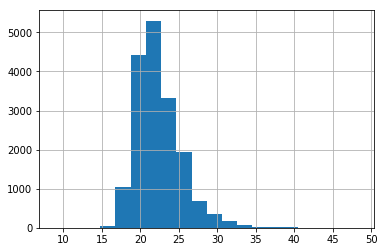

In [130]:
#user_attr = pd.read_csv(USER_ATTR)
user_attr.bmi.hist(bins=20)

In [124]:
user_attr['bmi'] = (user_attr['weight_lbs'] / user_attr['height_in'].pow(2))*703

In [139]:
user_attr.to_dict('records')[0]

{'standard_size': 0.0,
 'height_in': 68.0,
 'weight_lbs': 110.0,
 'bmi': 16.72361591695502}

In [133]:
df = pd.DataFrame(g.index)
user_attr.set_index('user_id', inplace=True)
df = df.join(user_attr,on='user_id',how='left')

In [137]:
(60 - df.height_in.min()) / 2

3.0